
# 1 bit Compressive Sensing

This example demonstrates the following features
- Adquisition step: Making 1-bit quantized compressive measurements of a sparse signal. Quantization can be considered as  an extreme noisy distortion of the compressed measurement.
- Recovering step: Recovering the original signal using the BIHT (Binary Iterative Hard Thresholding) algorithm.


Let's import necessary libraries 
*   [jax](https://github.com/google/jax): library for high-performance machine learning and numerical computations.
*   [cr-sparse](https://github.com/carnotresearch/cr-sparse): library for sparse signal represesentation with JAX.
* [cr-nimble](https://github.com/carnotresearch/cr-nimble): library for iterative algorithms for numerical linear algebra with JAX.

In [1]:
import jax.numpy as jnp  # Accelerated numpy library.
from jax.numpy.linalg import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

import cr.nimble as cnb
import cr.sparse as crs
import cr.sparse.dict as crdict
import cr.sparse.data as crdata
import cr.sparse.cs.cs1bit as cs1bit

import time

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Setup



In [2]:
# Number of measurements
M = 250
# Ambient dimension
N = 500
# Sparsity level
K = 5

## Sensing Matrix
_Function help_
- [gaussian_mtx()](https://cr-sparse.readthedocs.io/en/latest/source/_autosummary/cr.sparse.dict.gaussian_mtx.html?highlight=gaussian_mtx)


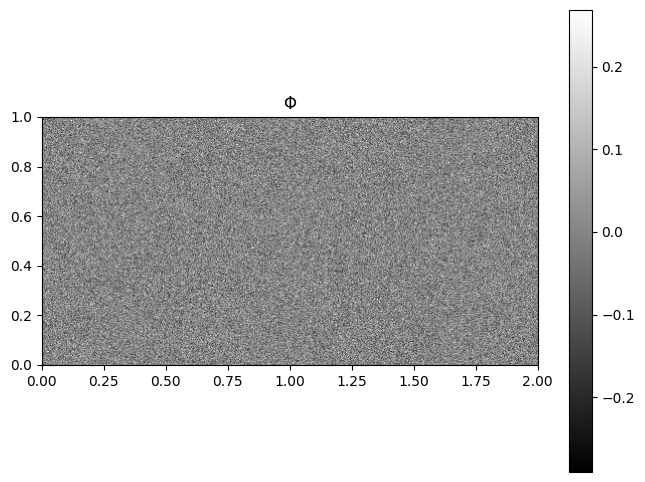

In [3]:
# High level
Phi = crdict.gaussian_mtx(cnb.KEYS[0], M, N, normalize_atoms=True) 

# Frame bound (You can ignore this)
s0 = crdict.upper_frame_bound(Phi)  # Computes the upper frame bound for a dictionary. Upper frame bound: https://en.wikipedia.org/wiki/Frame_(linear_algebra)

# Plot sensing matrix
fig=plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(Phi, extent=[0, 2, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'$\Phi$');

## K-sparse signal
_Function help_
- [sparse_normal_representations()](https://cr-sparse.readthedocs.io/en/latest/source/_autosummary/cr.sparse.data.sparse_normal_representations.html?highlight=sparse_normal_representations): Generates a set of sparse model vectors with normally distributed non-zero entries.



omega = [164 238 265 298 317]


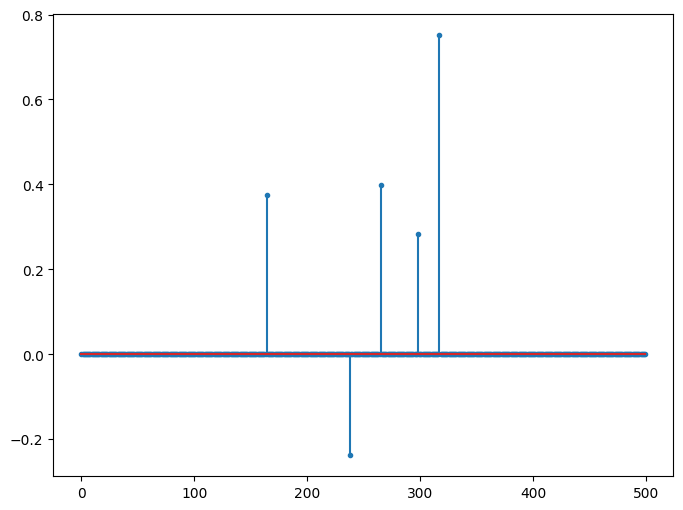

In [4]:
# Generation of a random sparse vector.
x, omega = crdata.sparse_normal_representations(cnb.KEYS[1], N, K)

# Normalize signal
x = x / norm(x)

# The support indices
print(f"omega = {omega}")

# Plot sparse signal
fig=plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(x, markerfmt='.');

## Measurement process or acquisition step
1-bit quantized compressive measurements

Elapse time: 2.3559e-02 seconds


Text(0.5, 1.0, 'Compressive measurement with binarization')

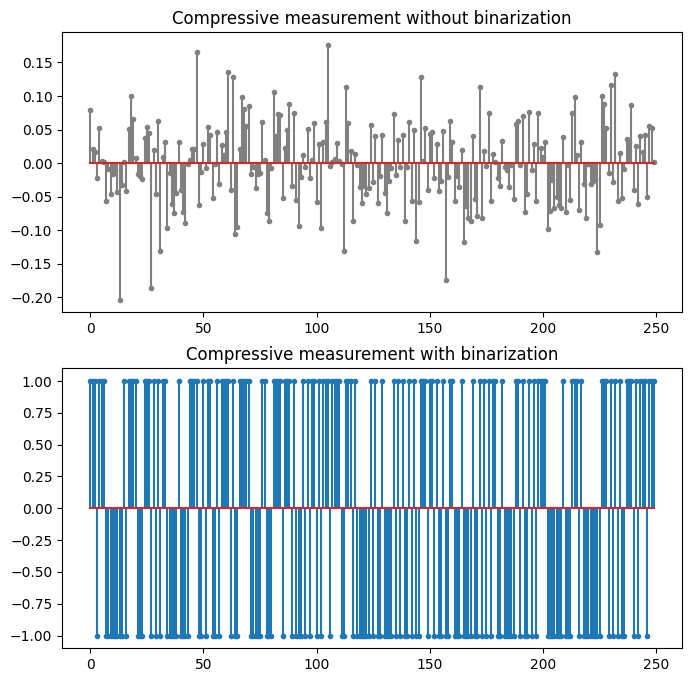

In [5]:
# Sparse matrix multiplication
start = time.time()
u = Phi @ x
y = jnp.sign(u) # -> Binarization: extreme signal distorsion
end = time.time()
print(f'Elapse time: {end - start:.4e} seconds')

# Plot compressive vector
fig=plt.figure(figsize=(8, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Compressive measurement without binarization')
plt.stem(u, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(y, markerfmt='.');
plt.title('Compressive measurement with binarization')

## Signal Reconstruction/Recovering using BIHT
_Function help_
- [cs1bit.biht_jit](https://cr-sparse.readthedocs.io/en/latest/source/_autosummary/cr.sparse.cs.cs1bit.biht_jit.html?highlight=cs1bit.biht_jit): Solves the 1-bit (based on sign) compressive sensing problem using Binary Iterative Hard Thresholding.
- [build_signal_from_indices_and_values()](https://cr-sparse.readthedocs.io/en/latest/source/_autosummary/cr.sparse.build_signal_from_indices_and_values.html?highlight=build_signal_from_indices_and_values): Builds a sparse signal from its non-zero entries (specified by their indices and values).


In [6]:
# Step size for the update step
tau = 0.98 * s0

# Solution
start = time.time()
sol = cs1bit.biht_jit(Phi, y, K, tau, max_iters=1000)

# Reconstructed signal
x_rec = cnb.dsp.build_signal_from_indices_and_values(N, sol.I, sol.x_I)
end = time.time()
print(f'Elapse time: {end - start:.4e} seconds')
I = sol.I

Elapse time: 7.7833e-02 seconds


## Verification



I = [164 238 265 298 317]


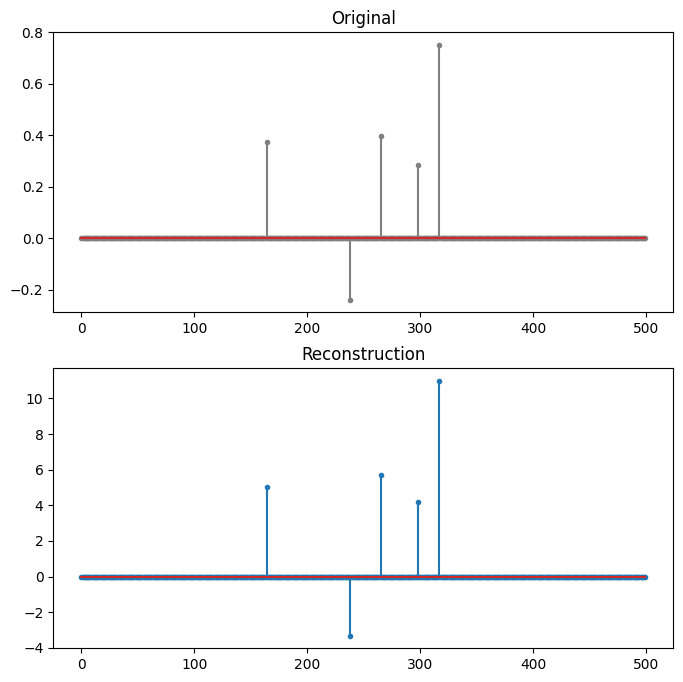

In [7]:
# Plot original and reconstructed signals
fig=plt.figure(figsize=(8, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Original')
plt.stem(x, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(x_rec, markerfmt='.');
plt.title('Reconstruction')

# Recovered support
I = jnp.sort(I)
print(f"I = {I}")

Check if the support and sparse signal is recovered correctly.



In [8]:
# Check if correctly recovered
print(f'Support correctly recovered?: {jnp.array_equal(omega, I)}')

# Normalize recovered signal
x_rec = x_rec / norm(x_rec)

# The norm of error
print(f'Error: {norm(x - x_rec):.4e}')

Support correctly recovered?: True
Error: 2.9202e-02
